In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd vehicle_image

C:\Users\mini_beast\vehicle_image


C:\Users\mini_beast\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 9639-793C

 Directory of C:\Users\mini_beast\vehicle_image

07/09/2024  15:25    <DIR>          .
07/09/2024  15:26    <DIR>          ..
07/09/2024  15:04    <DIR>          data
07/09/2024  15:23                 0 video_1440p.mp4.f271.webm.part
07/09/2024  15:16        17.570.948 video_low.mp4
07/09/2024  14:53    <DIR>          yolov5
07/09/2024  15:15        14.808.437 yolov5s.pt
               3 File(s)     32.379.385 bytes
               4 Dir(s)  375.702.495.232 bytes free


In [4]:
# !git clone https://github.com/ultralytics/yolov5

In [5]:
# !pip install -U pycocotools

In [6]:
# !pip install -qr yolov5/requirements.txt 

In [7]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv("data/train_solution_bounding_boxes (1).csv")
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [8]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_6160


(380, 676, 3)

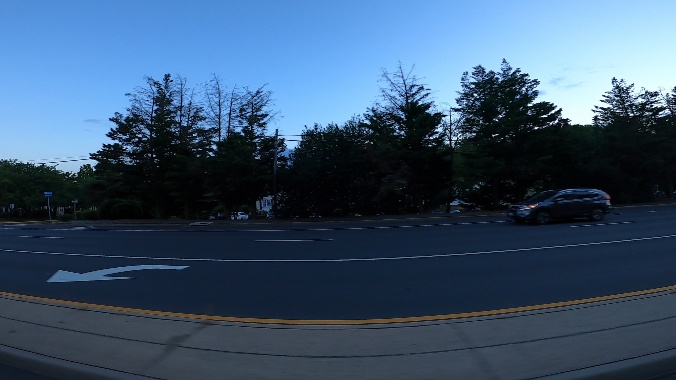

In [9]:
image = random.choice(index)
Image(filename=f'data/training_images/{image}.jpg',width=600)

In [11]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [14]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=data/testing_images, data=yolov5\data\coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-365-g12b577c8 Python-3.12.4 torch-2.4.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING  --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 C:\Users\mini_beast\vehicle_image\data\testing_images\vid_5_25100.jpg: 416x704 (no detections), 41.1ms
image 2/175 C:\Users\mini_beast\vehicle_image\data\testing_images\vid_5_25120.jpg: 416x704 (no detections), 31.2ms
image 3/175 C:\Users\

In [22]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("yolov5/runs/detect/exp2"):
    print(dirpath, dirnames, filenames)
    predicted_files.extend(filenames)

yolov5/runs/detect/exp2 [] ['vid_5_25100.jpg', 'vid_5_25120.jpg', 'vid_5_25140.jpg', 'vid_5_25160.jpg', 'vid_5_25180.jpg', 'vid_5_25200.jpg', 'vid_5_25220.jpg', 'vid_5_25240.jpg', 'vid_5_25260.jpg', 'vid_5_26320.jpg', 'vid_5_26400.jpg', 'vid_5_26420.jpg', 'vid_5_26560.jpg', 'vid_5_26580.jpg', 'vid_5_26600.jpg', 'vid_5_26620.jpg', 'vid_5_26640.jpg', 'vid_5_26660.jpg', 'vid_5_26680.jpg', 'vid_5_26700.jpg', 'vid_5_26720.jpg', 'vid_5_26740.jpg', 'vid_5_26760.jpg', 'vid_5_26780.jpg', 'vid_5_26800.jpg', 'vid_5_26820.jpg', 'vid_5_26840.jpg', 'vid_5_26860.jpg', 'vid_5_26880.jpg', 'vid_5_26900.jpg', 'vid_5_26920.jpg', 'vid_5_26940.jpg', 'vid_5_26960.jpg', 'vid_5_26980.jpg', 'vid_5_27240.jpg', 'vid_5_27260.jpg', 'vid_5_27280.jpg', 'vid_5_27300.jpg', 'vid_5_27320.jpg', 'vid_5_27360.jpg', 'vid_5_27380.jpg', 'vid_5_27400.jpg', 'vid_5_27420.jpg', 'vid_5_27440.jpg', 'vid_5_27460.jpg', 'vid_5_27480.jpg', 'vid_5_27500.jpg', 'vid_5_27520.jpg', 'vid_5_27540.jpg', 'vid_5_27560.jpg', 'vid_5_27580.jpg', 'vi

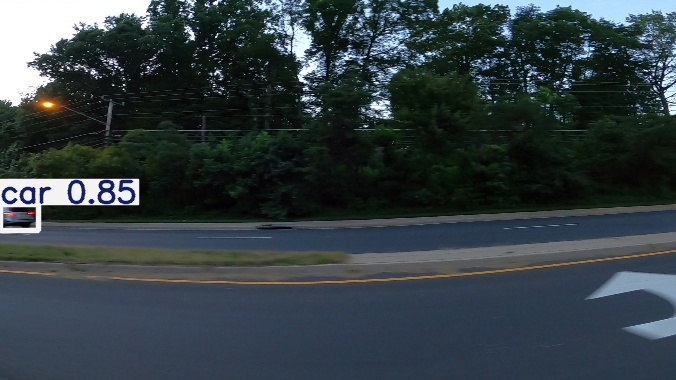

In [24]:
Image(filename=f'yolov5/runs/detect/exp2/{random.choice(predicted_files)}')

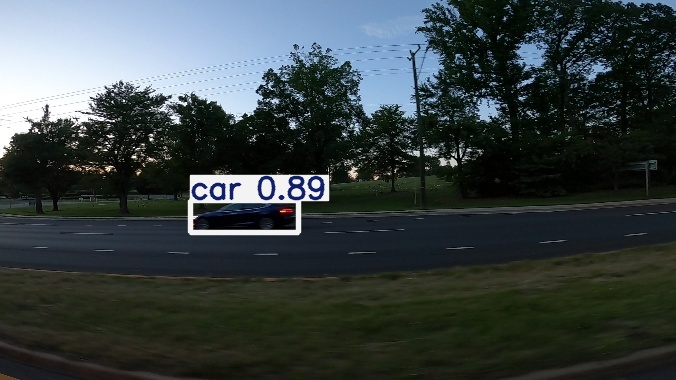

In [28]:
Image(filename=f'yolov5/runs/detect/exp2/{random.choice(predicted_files)}')

In [32]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 9639-793C

 Directory of C:\Users\mini_beast\vehicle_image

07/09/2024  15:25    <DIR>          .
07/09/2024  15:25    <DIR>          ..
07/09/2024  15:04    <DIR>          data
07/09/2024  15:23                 0 video_1440p.mp4.f271.webm.part
07/09/2024  15:16        17.570.948 video_low.mp4
07/09/2024  14:53    <DIR>          yolov5
07/09/2024  15:15        14.808.437 yolov5s.pt
               3 File(s)     32.379.385 bytes
               4 Dir(s)  375.723.610.112 bytes free


In [8]:
!python yolov5/detect.py --weights yolov5s.pt --source video_1440p.mp4 --conf 0.4 --img-size 640 --classes 2 5 7

detect: weights=['yolov5s.pt'], source=video_1440p.mp4, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=[2, 5, 7], agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-365-g12b577c8 Python-3.12.4 torch-2.4.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
video 1/1 (1/8665) C:\Users\mini_beast\vehicle_image\video_1440p.mp4: 384x640 6 cars, 40.5ms
video 1/1 (2/8665) C:\Users\mini_beast\vehicle_image\video_1440p.mp4: 384x640 6 cars, 29.2ms
video 1/1 (3/8665) C:\Users\mini_beast\vehicle_image\video_1440p.mp4: 384x640 7 cars, 1 truck, 41.8ms
video 1/1 (4/8665) C:\Users\mini_beast\vehicle_image\video